In [56]:
import os
import re
import nltk
import string
import pandas as pd
import multiprocessing
from string import digits
from textblob import TextBlob
from nltk import word_tokenize
import matplotlib.pyplot as plt
from autocorrect import Speller
from nltk.corpus import wordnet
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.linear_model import LinearRegression
from nltk.tokenize import sent_tokenize,word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download("words")
# nltk.download("stopwords")

In [4]:
def get_files(path):
    return os.listdir(path)

In [5]:
def clean(word):
    word2 = word.translate(re.sub(r'\d+', '', word).maketrans('', '', string.punctuation)).lower()
    remove_digits = str.maketrans('', '', digits)
    return word2.translate(remove_digits)

In [6]:

delete_words = set(nltk.corpus.words.words())

def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in delete_words or not w.isalpha())

In [7]:
def isValid(word):
    if len(word) == 2 and word[1] == 'a':
        return False
    return True

In [8]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [41]:
spell = Speller(lang='en')
def clear_document(sentences):
    new_words = ''
    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    for sentence in sentences:
        new_words += sentence.strip()
    new_words = clean(new_words)# regexp stemmer (puctuation cleaning)
    tokinezed = word_tokenize(new_words) #tokenization
    tags = nltk.pos_tag(tokinezed) #pos tagging
    correct_sentence = []
    for i in tags:
        position = get_wordnet_pos(i[1])
        if position == '':
            correct_sentence.append(lemmatizer.lemmatize(word=i[0]))  # lemmatization
        else:
            correct_sentence.append(lemmatizer.lemmatize(word=i[0], pos=position))  # lemmatization 
    correct_sentence = [lemmatizer.lemmatize(i) for i in correct_sentence]
    correct_sentence = [spell(i) for i in correct_sentence]
    stop_words = []
    stops = stopwords.words('english') #stop word removal
    [stop_words.append(word.replace("'", '') ) for word in stops]
    stop_words = list(set(stop_words))
    filtered_words = list(map(clean_sent, correct_sentence))
    filtered_words = [word for word in filtered_words if word not in stops and isValid(word)]
    while(True):
        if '' in filtered_words:
            filtered_words.remove('')
        else:
            break
    return ' '.join(filtered_words)

In [42]:
def clean_document(fileName):
    with open(fileName[0]) as f:
        words = f.readlines()
        cleaned_document = clear_document(words)
    with open(fileName[1],"w") as f:
        f.write(cleaned_document)

In [43]:
path_list = ['review_polarity/txt_sentoken/pos/', 'review_polarity/txt_sentoken/neg/']
path_list_2 = ['cleaned/pos/', 'cleaned/neg/']
for i in range(2):
    path = path_list[i]
    path_2 = path_list_2[i]
    files = get_files(path)
    filenames = [(path + file, path_2+file) for file in files]
    with multiprocessing.Pool(20) as p:
        # Use the pool to read all the files in parallel
        p.map(clean_document, filenames)

In [9]:
path_list_2 = ['cleaned/pos/', 'cleaned/neg/']
all_documents = []
sentiments = []
for i in range(2):
    path = path_list_2[i]
    files = get_files(path)
    for file in files:
        with open(path+file) as f:
            sentence = f.readline()
        all_documents.append(sentence)
        sentiments.append(path[-4:-1])

In [10]:
df = pd.DataFrame(columns=['text'], data=all_documents)

In [11]:
df['number_of_words'] = df['text'].apply(lambda x : len(TextBlob(str(x)).words))
df['polarity'] = df['text'].apply(lambda x : TextBlob(str(x)).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x : TextBlob(str(x)).sentiment.subjectivity)
df['number_of_letters'] = df['text'].apply(lambda x: sum([len(i) for i in x.split(' ')]))

In [12]:
df

,text,number_of_words,polarity,subjectivity,number_of_letters
0,assume nothing phrase perhaps one used first i...,376,0.167592,0.647744,2038
1,plot male model also dumb impressionable reaso...,286,0.025651,0.559099,1601
2,actually fan original flick name star mill twi...,717,0.189720,0.537842,3945
3,movie thats highly build human show review boa...,184,0.064375,0.360104,970
4,good hunt two movie one independent take strug...,145,0.207433,0.499777,909
...,...,...,...,...,...
1995,synopsis meteorite desert community college pr...,137,0.119066,0.555123,878
1996,anniversary slaying love best friend still bes...,252,0.148363,0.598198,1400
1997,coincide emerge popularity movie deal anything...,155,0.014219,0.464103,935
1998,highflying hong style make way classic pretty ...,209,-0.047128,0.451001,1202


In [13]:
bag_of_words_model = CountVectorizer(max_features=10)

In [14]:
bag_of_word_df = pd.DataFrame(bag_of_words_model.fit_transform(all_documents).todense())
bag_of_word_df.columns = sorted(bag_of_words_model.vocabulary_)
bag_of_word_df.head()

,character,film,get,go,good,like,make,movie,one,see
0,6,2,1,3,2,0,2,1,6,3
1,2,6,3,1,0,4,1,4,1,4
2,1,18,2,2,5,7,7,4,12,7
3,1,4,1,3,2,0,1,6,0,1
4,1,2,0,0,5,2,1,1,1,0


In [15]:
tfidf_model = TfidfVectorizer(max_features=10)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(all_documents).todense())
tfidf_df.columns = tfidf_model.get_feature_names_out()
tfidf_df.head()

,character,film,get,go,good,like,make,movie,one,see
0,0.620535,0.171225,0.101604,0.320219,0.217368,0.000000,0.191307,0.092488,0.523057,0.326748
1,0.216574,0.537834,0.319149,0.111760,0.000000,0.415934,0.100153,0.387354,0.091276,0.456156
2,0.044053,0.656394,0.086556,0.090931,0.231469,0.296113,0.285204,0.157581,0.445590,0.324748
3,0.131662,0.435953,0.129347,0.407652,0.276720,0.000000,0.121771,0.706450,0.000000,0.138655
4,0.163510,0.270704,0.000000,0.000000,0.859143,0.314024,0.151228,0.146223,0.137825,0.000000


## We Chose Bag Of Words

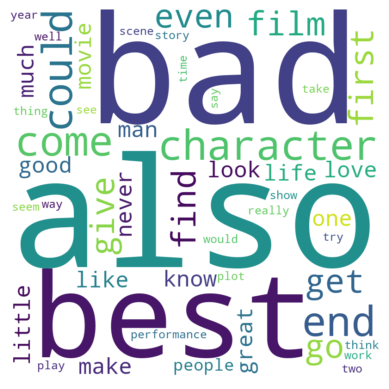

In [17]:
bag_of_words_model = CountVectorizer(max_features=50)
bag_of_word_df = pd.DataFrame(bag_of_words_model.fit_transform(all_documents).todense())
bag_of_word_df.columns = bag_of_words_model.get_feature_names_out()
bests2= list(bag_of_word_df.columns)
wordcloud = WordCloud(width = 800, height = 800, 
    background_color ='white', 
    max_words=50,
    stopwords = [],
    min_font_size = 10).generate(' '.join(bests2))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

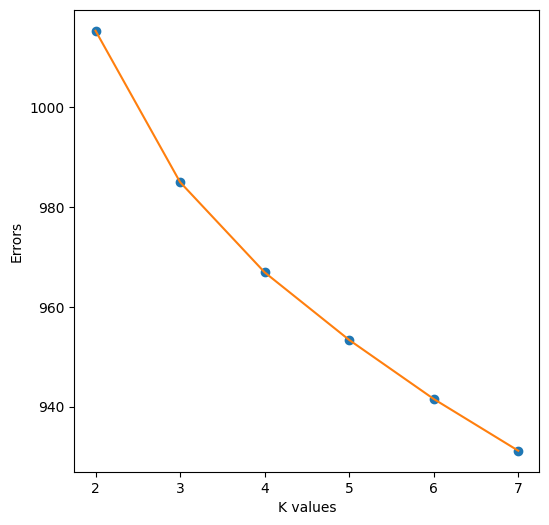

In [44]:
scores=[]
for k in [2,3,4,5,6,7]:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_df.to_numpy())
    scores.append(-kmeans.score(tfidf_df.to_numpy()))
plt.figure(figsize=(6, 6))
plt.plot([k for k in range(2,8)], scores, 'o')
plt.plot([k for k in range(2,8)], scores)
plt.xlabel('K values')
plt.ylabel('Errors')
plt.show()

In [47]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(tfidf_df)
y_kmeans = kmeans.predict(tfidf_df)
df['obtained_clusters'] = y_kmeans

/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [48]:
df

,text,number_of_words,polarity,subjectivity,number_of_letters,obtained_clusters
0,assume nothing phrase perhaps one used first i...,376,0.167592,0.647744,2038,0
1,plot male model also dumb impressionable reaso...,286,0.025651,0.559099,1601,0
2,actually fan original flick name star mill twi...,717,0.189720,0.537842,3945,0
3,movie thats highly build human show review boa...,184,0.064375,0.360104,970,1
4,good hunt two movie one independent take strug...,145,0.207433,0.499777,909,0
...,...,...,...,...,...,...
1995,synopsis meteorite desert community college pr...,137,0.119066,0.555123,878,1
1996,anniversary slaying love best friend still bes...,252,0.148363,0.598198,1400,1
1997,coincide emerge popularity movie deal anything...,155,0.014219,0.464103,935,0
1998,highflying hong style make way classic pretty ...,209,-0.047128,0.451001,1202,0


In [49]:
df['actual_cluster'] = [0 for _ in range(1000)] + [1 for _ in range(1000)]

In [52]:
yourdf1 = df[df[['actual_cluster','obtained_clusters']].nunique(axis=1) == 1]

In [59]:
linreg = LinearRegression()
linreg.fit(tfidf_df,df['actual_cluster'])
linreg.predict(tfidf_df)
df['predicted_score_from_linear_regression'] = linreg.predict(tfidf_df)
df[['actual_cluster', 'predicted_score_from_linear_regression']]

,actual_cluster,predicted_score_from_linear_regression
0,0,0.433357
1,0,0.363312
2,0,0.141182
3,0,0.443315
4,0,0.405821
...,...,...
1995,1,0.566571
1996,1,0.690213
1997,1,0.304101
1998,1,0.587601


In [60]:
tp,fp,tn,fn = 0,0,0,0
for i in range(len(df['predicted_score_from_linear_regression'])):
    if i <1000:
        if df['predicted_score_from_linear_regression'][i]<0.5:
            tp +=1
        else:
            fp+=1
    else:
        if df['predicted_score_from_linear_regression'][i]<0.5:
            fn +=1
        else:
            tn +=1

In [62]:
print([[tp,fp], [fn,tn]])

[[763, 237], [274, 726]]
